<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Overview" data-toc-modified-id="Overview-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span>Overview</a></span></li></ul></li><li><span><a href="#Tools" data-toc-modified-id="Tools-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Tools</a></span></li><li><span><a href="#Select-your-motif" data-toc-modified-id="Select-your-motif-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Select your motif</a></span></li><li><span><a href="#Check-the-motif's-point-symmetry" data-toc-modified-id="Check-the-motif's-point-symmetry-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Check the motif's point symmetry</a></span></li><li><span><a href="#Select-the-global-pattern-symmetry" data-toc-modified-id="Select-the-global-pattern-symmetry-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Select the global pattern symmetry</a></span></li><li><span><a href="#Proceed-to-Step-3" data-toc-modified-id="Proceed-to-Step-3-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Proceed to Step 3</a></span></li></ul></div>

In [35]:
import json, os, sys
import numpy as np
import pandas as pd
import ipywidgets as widgets
import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Overview
--------
This is **STEP 2** in the design procedure. If you plan to use default motifs you may proceed; otherwise go to `motif_library/Create_Motifs.ipynb` to design your motif first.

# Tools

In [2]:
library = '../motif_library/'
motif_coords = None
motif_types = None
motif_point_symmetry = None
induced = 'c1'

motif_selector = widgets.Dropdown(
    options=[f for f in os.listdir(library) if f.endswith('.json')],
    description='Motif',
    disabled=False,
    value=None
)

def on_motif_change(v):
    global motif_coords
    global motif_types
    global motif_point_symmetry
    info = json.load(open(library+v['new'], 'r'))
    motif_coords = info['coords'] 
    motif_types = info['types'] 
    motif_point_symmetry = info['symmetry'] 

motif_selector.observe(on_motif_change, names='value')

induced_selector = widgets.ToggleButtons(
    options=['Ignore (c1)', 'Use motif'],
    description=r'$S(\mathcal{P}|M):$',
    disabled=False,
    button_style='info', 
    tooltips=['Do not extend any of motif\'s symmetry to the tiling', 'Use some of motif\'s symmetry in tiling'],
)

def on_induced_change(v):
    global induced
    if v['new'] == "Use motif":
        induced = motif_point_symmetry
    else:
        induced = 'c1'

induced_selector.observe(on_induced_change, names='value')

def plot(coords):
    coords = np.array(coords)
    plt.plot(coords[:,0], coords[:,1], 'o')
    plt.gca().axis('equal')
    
def convert_pym_sch(sch):
    """
    Convert 3D Schoenflies notation from pymatgen to 2D.
    
    All "molecules" are expected to be planar so the "z"-plane
    is effectively a "horizontal" mirror. 
    
    This also is designed to specifically handle to the 
    way that pymatgen responds; if pymatgen conventions change
    this might need to be updated.
    
    See visualizations and references here:
    * https://demonstrations.wolfram.com/MolecularPointGroups/
    * https://en.wikipedia.org/wiki/Schoenflies_notation
    * https://en.wikipedia.org/wiki/Point_groups_in_three_dimensions
    """

    if sch == "C1" or sch == "C1h" or sch == "C1v" or sch == "Cs": # From wiki
        return "c1"
    elif sch == "C2v" or sch == "D1h": # From wiki
        return "d1"
    elif sch.endswith("h") :
        return sch[:2].lower() # Dxh = dx, Cxh = cx
    else:
        raise Exception("unrecognized Schoenflies point group {}".format(sch))

# 1. Select your motif

In [3]:
display(motif_selector)

Dropdown(description='Motif', options=('c2_taiji.json', 'd2_dumbbell.json', 'dinf_circle.json', 'd1_vitruvian.…

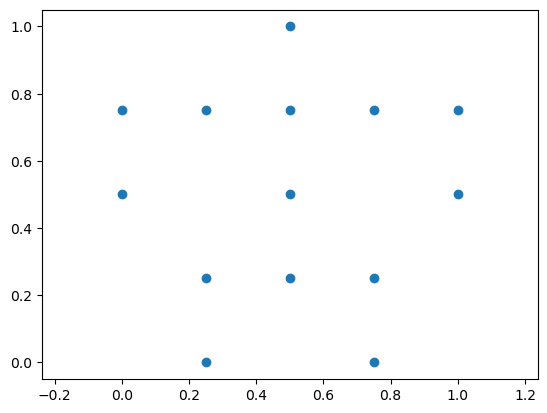

In [4]:
plot(motif_coords)

# 1b. (Optional) Check the motif's point symmetry

You must have [pymatgen](https://pymatgen.org/index.html) installed for this to work, otherwise you can consider doing this manually and can skip ahead.

**Note**: this is intended to be a helpful check, but ultimately symmetry determination has a numerical precision associated with it.  If points are too close together, or tolerances poor, a bad assignment can be made.  The user should always check these results make sense. A circle, for example, if represented by a set of points always has finite symmetry, not $d_{\infty}$. This section is just to provide an attempted check of the motif the user manually created (and assigned a 2D point symmetry).  

In [41]:
if 'pymatgen' in sys.modules:
    import pymatgen.symmetry.analyzer as psa
    from pymatgen.core.structure import Molecule
    from scipy.spatial import distance_matrix
    
    # For numerical reasons, pymatgen works best when things are at least 1A apart, so center and scale
    # so nearest particles are 1 "unit" apart
    min_d = np.min(distance_matrix(motif_coords, motif_coords)[np.triu_indices(len(motif_coords), 1)])
    safer_coords = (motif_coords - np.mean(motif_coords, axis=0))/min_d

    mol = Molecule(
        species=["H"]*len(safer_coords),
        coords=np.hstack((np.array(safer_coords), np.zeros((len(safer_coords),1)))),
        validate_proximity=True
    )

    a = psa.PointGroupAnalyzer(mol, tolerance=0.3, eigen_tolerance=0.01)
    pmg_symm = convert_pym_sch(a.sch_symbol)
    
    # Check that pymatgen agrees with the library file
    assert(motif_point_symmetry == pmg_symm), 'pymatgen and library file do not agree on symmetry'
else:
    print('pymatgen is not installed, cannot perform symmetry check')

pymatgen is not installed, cannot perform symmetry check


# 2. Select the global pattern symmetry

Remember, if a motif has a certain symmetry (e.g., $S(M) = c6$), it can induce any of its subgroups (e.g., $S(\mathcal{P}|M) = c3$)

1. [**safe**] If $S(\mathcal{P}|M)$ = $S(M)$ then you can use these IH tiles without fear. The escherization *algorithm* will place the motif so that it induces all of its symmetries on the pattern, and since the motif has no more, there are no potential problems. 

2. [**forbidden**] 
* Cause 1: A pattern type is forbidden if it requires the induction of a set of symmetries the motif does not have; i.e., $S(\mathcal{P}|M) \not\le S(M)$; for example, you cannot induce d3 if the motif has d4 symmetry. Conversely, in this example it might be possible if the motif has d6 symmetry (see *dangerous* category below).
* Cause 2: If a proper subset (proper subgroup) of the motif's symmetries are induced on the pattern, $S(\mathcal{P}|M) < S(M)$, you have to check that the motif's "extra" symmetries don't cause it to be strictly forbidden. 

    > Check for all $X$ such that $S(\mathcal{P}|M) < X \le S(M)$: If any such $X$ is a (minimal) forbidden supergroup, then this tile cannot be used since it will certainly create a different pattern than expected.

    In other words, when the motif induces $S(\mathcal{P}|M)$ by using some of its symmetries, at least some of its extra symmetries **always** yield a net result of an even more symmetric global pattern which changes the pattern type (not always the symmetry, though, but usually - cf. G&S, PP31->32 and PP40->41).  As best practice, I will just take this as a requirement. 

3. [**dangerous**] There is also a third case where $S(\mathcal{P}|M) < S(M)$ and neither $S(M)$, nor any of its subgroups, are strictly forbidden, but if the motif is oriented on tile in a special way or the tile has the right shape, for example, it is possible to change the pattern type. Consider the following example:

    * If $S(M) =$ d2, can make PP20 with IH 17, 74 without any problem. [**safe**]
    * If $S(M) =$ d4, it is possible to make PP20 with these IH tiles, and d4 is not *strictly* forbidden. [**dangerous**]
    * However, if those tiles have a certain shape then the cmm group these belong to can induce d4 which promotes the pattern's overall symmetry to p4m, so d4 is *sometimes* incorrect.  Of course, c1 is always a subgroup.
    
The **safe** and **forbidden** cases are the "black and white" ends of the spectrum; the "dangerous" ones are a gray area.  They offer the possibility of creating additional symmetries that might not be strictly safe, but require that you be careful with your design. If we make a dangerous choice, we can gain insight into the problems that might arise by using the `watch_out_for` function.

Some interesting limits:
* $S(M) = d_{\infty}$ (Isotropic circle - None are safe, all pattern types with no strictly forbidden supergroups are dangerous, while the rest are forbidden)
* $S(M) = c1$ (Asymmetric motif - the 46 FD tiles with MTPS which are "Primitive" are all safe, 0 are dangerous, while the other 47 tiles are forbidden)

Notes on Notation:
* [Subgroups](https://mathworld.wolfram.com/Subgroup.html)
* [Proper Subgroups](https://mathworld.wolfram.com/ProperSubgroup.html)
* [Symbols](https://www.mathsisfun.com/sets/symbols.html)

In [13]:
## To see this example, uncomment the line below
# motif_point_symmetry = 'd4'

In [5]:
import table
safe, dangerous, forbidden = table.prioritize(motif_point_symmetry)     

In [6]:
safe.style.hide_index()

Pattern Type,Symmetry Group $S(\mathcal{P})$,"Induced Group, $S(\mathcal{P}|M)$",Motif Transitive Proper Subgroups of $S(\mathcal{P})$,Minimal Forbidden Supergroups,Isohedral Tiling Type IH
PP4,pm,d1,"['p1', 'pg', 'cm', '*']",d2,[64]
PP6,cm,d1,"['p1', 'pg']",d2,"[12, 14, 68]"
PP13,pmg,d1,"['pg', 'p2', 'pgg']",,"[13, 15, 66, 69]"
PP15,pmm,d1,"['pm', 'p2', 'pmg(2)', 'cmm', '*']",,[65]
PP19,cmm,d1,"['cm', 'p2', 'pgg', 'pmg']",,"[26, 67, 91]"
PP25,p31m,d1,['p3'],,"[16, 36]"
PP28,p3m1,d1,['p3'],,[35]
PP35,p4g,d1,"['pgg', 'p4']",,"[29, 71]"
PP38,p4m,d1,"['cmm', 'p4', 'p4g', '*']",,[82]
PP39,p4m,d1,"['pmm', 'p4', 'p4g']",,[70]


In [7]:
dangerous.style.hide_index()

Pattern Type,Symmetry Group $S(\mathcal{P})$,"Induced Group, $S(\mathcal{P}|M)$",Motif Transitive Proper Subgroups of $S(\mathcal{P})$,Minimal Forbidden Supergroups,Isohedral Tiling Type IH
PP1,p1,c1,['Primitive'],c2,"[1, 41]"
PP2,pg,c1,['Primitive'],dinf,"[2, 3, 43, 44]"
PP3,pm,c1,['Primitive'],dinf,[42]
PP5,cm,c1,['Primitive'],dinf,"[22, 45, 83]"
PP7,p2,c1,['Primitive'],,"[4, 23, 46, 47, 84]"
PP9,pgg,c1,['Primitive'],,"[5, 6, 25, 27, 51, 52, 53, 86]"
PP11,pmg,c1,['Primitive'],,"[24, 49, 50, 85]"
PP14,pmm,c1,['Primitive'],,[48]
PP17,cmm,c1,['Primitive'],,"[54, 78]"
PP21,p3,c1,['Primitive'],,"[7, 33]"


In [33]:
# Pay attention to the S(P) column which indicates possible symmetries that could result instead of what you want
# table.watch_out_for(17, dangerous, motif_point_symmetry).style.hide_index()

In [27]:
forbidden.style.hide_index()

Pattern Type,Symmetry Group $S(\mathcal{P})$,"Induced Group, $S(\mathcal{P}|M)$",Motif Transitive Proper Subgroups of $S(\mathcal{P})$,Minimal Forbidden Supergroups,Isohedral Tiling Type IH
PP8,p2,c2,"['p1', '*']",,"[8, 57]"
PP10,pgg,c2,['pg'],dinf,"[9, 59]"
PP12,pmg,c2,"['pg', 'pm', 'pgg', '*']",dinf,[58]
PP16,pmm,d2,"['p1', 'pg', 'pm(2)', 'cm', 'p2(3)', 'pgg', 'pmg(2)', 'cmm(3)', '*(2)']",,[72]
PP18,cmm,c2,"['cm', 'pgg', 'pmm']",dinf,[60]
PP20,cmm,d2,"['p1', 'pg', 'cm', 'p2(2)', 'pgg(2)', 'pmg']",,"[17, 74]"
PP22,p3,c3,"['p1', '*']",c6,[10]
PP24,p31m,c3,"['cm', 'p3m1']",dinf,[89]
PP26,p31m,d3,"['p1', 'pg', 'cm', 'p3(2)']",d6,[18]
PP29,p3m1,d3,"['p1', 'pg', 'cm', 'p3(2)', 'p31m']",d6,[19]


# Proceed to Step 3

3a. (optional) Visit [https://isohedral.ca/software/tactile/](https://isohedral.ca/software/tactile/) for an interactive experience with the tile you have selected.

3b. Use `examples/pso_safe` and/or `examples/pso_dangerous` for an illustration of how to use particle swarm optimization (PSO) to optimize a tile to "fit" around a motif and create a colloid out of the two.

3c. Run the optimization.

3d. Check your results. If you are using a "safe" choice, you are guaranteed to have the final desired symmetry; however, a "dangerous" choice may lead to something unexpected. In the latter case, use the `watch_out_for()` function to help point out what symmetry you might end up with instead.

* As best practice, you should **always** create a non-primitive unit cell (e.g., 3x3) and visually check what symmetry your final design will have.

* See `Colloid::unitCell()` C++ function and `examples/unit_cell`.